In [2]:
import numpy as np
import numba, sys
from numba import jit, njit, prange
import matplotlib.pyplot as plt

print("Python version: ", sys.version)
print("Numpy version: ", np.__version__)
print("Numba version: ", numba.__version__)


Python version:  3.6.4 | packaged by conda-forge | (default, Dec 23 2017, 16:54:01) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
Numpy version:  1.12.1
Numba version:  0.36.2


# Lorenz Curve

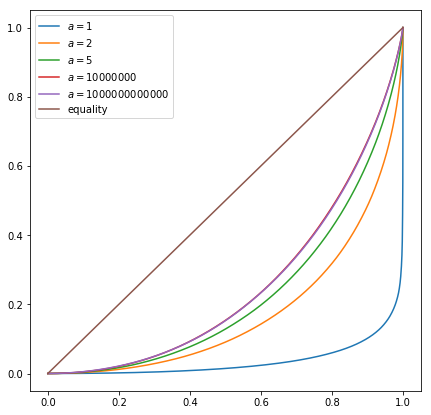

In [25]:
@njit
def lorenz(y):
    """
    Calculates the Lorenz Curve, a graphical representation of the distribution of income
    or wealth.
    
    It returns the cumulative share of people (x-axis) and the cumulative share of income earned 

    Parameters
    ----------
    y : array_like(float or int, ndim=1) 
        Array of income/wealth of each individual. 

    Returns
    -------
    cum_people : array_like(float, ndim=1)
        Cumulative share of people for each person index (i/n)
    cum_income : array_like(float, ndim=1)
        Cumulative share of income for each person index
    Notes
    -----
    
    References
    ----------
    https://en.wikipedia.org/wiki/Lorenz_curve
    
    Examples
    --------
    a_val, n = 3, 10_000
    y = np.random.pareto(a_val, size=n)
    f_vals, l_vals = lorenz(y)
    #Plot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(f_vals, l_vals, label="Pareto with a={0}".format(a_val))
    fig.suptitle("Pareto distribution with a={0}".format(a_val))
    
    """
    
    n = len(y)
    y = np.sort(y)
    s = np.zeros(n+1)
    s[1:] = np.cumsum(y)
    cum_people = np.zeros(n+1)
    cum_income = np.zeros(n+1)
    for i in range(1, n+1):
        cum_people[i] = i/n
        cum_income[i] = s[i] / s[n]
    return cum_people, cum_income


def non_jit_lorenz(y):
    n = len(y)
    y = np.sort(y)
    s = np.zeros(n+1)
    s[1:] = np.cumsum(y)
    cum_people = np.zeros(n+1)
    cum_income = np.zeros(n+1)
    for i in range(1, n+1):
        cum_people[i] = i/n
        cum_income[i] = s[i] / s[n]
    return cum_people, cum_income


# Testing
###############

from numpy.testing import assert_array_equal

def test_lorenz():
    """
    Tests `lorenz` function, which calculates the lorenz curve
    
    An income distribution where everyone has almost the same wealth should
    be similar to a straight line
    
    An income distribution where one person has almost the wealth should
    be flat and then shoot straight up when it approaches one
    """
    
    # Equal distribution
    
    assert_array_equal(1, 1)
    # Very uneven distribution
    
    
    assert_array_equal(1, 1)
    
test_lorenz()


#Plot

a_vals = (1, 2, 5, 10_000_000, 1_000_000_000_000)
n = 10_000
fig, ax = plt.subplots(figsize=(7, 7))
for a in a_vals:
    y = np.random.pareto(a, size=n)
    f_vals, l_vals = lorenz(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

In [16]:
n = 10_000_000
y = np.random.pareto(a_val, size=n)

%timeit _, _ = lorenz(y)

1.38 s ± 17.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
n = 10_000_000
y = np.random.pareto(a_val, size=n)

%timeit _, _ = non_jit_lorenz(y)

5.26 s ± 309 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Gini

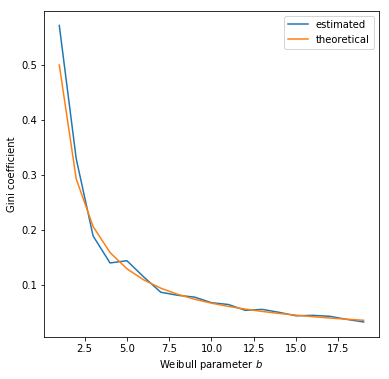

In [19]:
@njit(parallel=True)
def gini(y):
    n = len(y)
    i_sum = np.zeros(n)
    for i in prange(n):
        for j in range(n):
            i_sum[i] += abs(y[i] - y[j])
    return np.sum(i_sum) / (2 * n * np.sum(y))


#For a Weibull with parameter `a`, Gini coefficient is known to be
# G = 1 - 2^(-1/a)

a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

fig, ax = plt.subplots(figsize=(6, 6))
for a in a_vals:
    y = np.random.weibull(a, size=n)
    ginis.append(gini(y))
    ginis_theoretical.append(1 - 2**(-1/a))
ax.plot(a_vals, ginis, label='estimated')
ax.plot(a_vals, ginis_theoretical, label='theoretical')
ax.legend()
ax.set_xlabel("Weibull parameter $b$")
ax.set_ylabel("Gini coefficient")
plt.show()


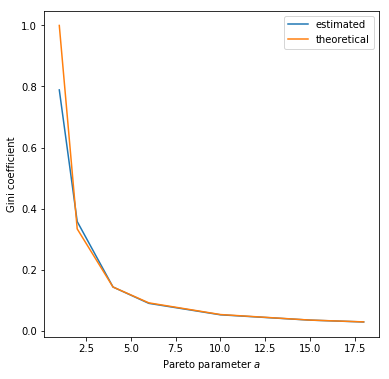

In [30]:
#For a Pareto distribution with parameter `a`, Gini coefficient is known to be
# G = 1 / (2a - 1)  with a > 1

#a_vals = range(1, 20)
a_vals = [1, 2, 4, 6, 10, 15, 18]
ginis = []
ginis_theoretical = []
n = 5_000

fig, ax = plt.subplots(figsize=(6, 6))
for a in a_vals:
    # The numpy pareto isn't really a Pareto, but a Pareto II or Lomax
    # See the discussion here: 
    # https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.pareto.html
    y = (np.random.pareto(a, size=n) + 1 )*2
    ginis.append(gini(y))
    ginis_theoretical.append(1 / (2*a - 1))
    #ginis_theoretical.append(1 / (2*(a-1) - 1))
ax.plot(a_vals, ginis, label='estimated')
ax.plot(a_vals, ginis_theoretical, label='theoretical')
ax.legend()
ax.set_xlabel("Pareto parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()